In [1]:
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
#import tensorflow as tf
import torch
from torch_geometric.data import Data, DataLoader
import dgmc
from urllib.parse import urlparse
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def create_dict(table, col):
    table_dict = {}
    for ix, value in enumerate(table[col]):
        #print(value)
        if value != value:
            continue
        if value in table_dict:
            table_dict[value].append(ix)
        else:
            table_dict[value] = [ix]
    return table_dict


def search_table(table, column):
    connections = []
    lookup_dict = create_dict(table, column)
    for ix, value in enumerate(table[column]):
        if value in lookup_dict:
            for item in lookup_dict[value]:
                connections.append((ix, item, column, value))
    connections = pd.DataFrame(
        connections, 
        columns=['source', 'target', 'column', 'value']
    )
    return connections


def visualize(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()
    

## Load Data

In [3]:
zync = pd.read_csv("data/zync_session_tracking_orc_20210625_all.csv")
print(f"Zync data shape: {zync.shape}")

sizmek = pd.read_csv("data/sizmek_bidstream_raw_20210625_10k.csv")
print(f"Sizmek data shape: {sizmek.shape}")

# Fix column headers
zync.columns = [i.split(".")[1] for i in zync.columns]
sizmek.columns = [i.split(".")[1] for i in sizmek.columns]

def make_smaller(df, frac):
    new_df = df.copy()
    new_df = new_df.sample(frac=frac, replace=False)
    return new_df

#zync = make_smaller(zync, 0.1)
#sizmek = make_smaller(sizmek, 0.1)

Zync data shape: (99999, 16)
Sizmek data shape: (10000, 16)


In [4]:
sizmek.head(1)

,user_id,household_cluster_id,zeta_user_id,account_id,url,referrer_url,city_code,state_code,zip_code,dma_code,country_code,user_agent,mobile_id,ip,server_timestamp,dt
0,163543465731194,NaN,NaN,19967,http://mob.app.de.wetteronline.wetterapp,NaN,3103824.0,NaN,NaN,NaN,PL,Mozilla/5.0 (Linux; Android 11; SM-A715F Build...,b7f4d610-7879-4394-aa2b-bfb9f2b1c25b,31.0.26.0,1624622086664,20210625


In [5]:
zync.head(1)

,session_id,client,client_id,remote_addr,referrer,user_agent_platform,user_agent_language,user_agent_browser,user_agent_string,user_agent_version,timestamp,geo_data,partner_data,session,consent_data,dt
0,042daa1a-aa73-47f0-89f4-5ead6821767e:161417230...,disqus,c3rj9u181f91uc2,128.201.40.29,https://www.biorxiv.org/content/10.1101/560755...,windows,NaN,chrome,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,91.0.4472.114,1.624644e+09,"{""country"":""BR"",""subdivision"":""RJ"",""coordinate...",NaN,"{""clients"":{""appnexus"":null,""disqus"":""c3rj9u18...","{""gdpr"":null,""gdpr_consent"":null}",2021-06-25-18


## Transform Data

#### Create Edges
Parse the base url domain for increased matching and then apply the functions defined up top to create the list of edge connections within the dataset.

In [6]:
sizmek["url_domain"] = sizmek['url'].apply(
    lambda x: urlparse(x).netloc if pd.notnull(x) else x
)
sizmek_edges = search_table(sizmek, "url")
sizmek_edges.head(2)

,source,target,column,value
0,0,0,url,http://mob.app.de.wetteronline.wetterapp
1,0,1,url,http://mob.app.de.wetteronline.wetterapp


In [49]:
sizmek['zeta_user_id'].value_counts()[:3]

fa3e335a-6b70-45b0-a9fb-ac71d098a924:1613777483.13    4015
8fe07ef8-3b0f-4807-a047-1b25e88afdd3:1624070625.62     579
8504cfc5-a47f-4d2c-b151-8034b08d313d:1564656094.89     421
Name: zeta_user_id, dtype: int64

#### Create Features
Use a standard one-hot encoding method of select columns and transform to a new DataFrame

In [64]:
feature_cols = ["account_id", "referrer_url", "city_code", 
                "state_code", "dma_code", "country_code"]

feature_enc = OneHotEncoder(handle_unknown="ignore")
sizmek_features = pd.DataFrame(
    feature_enc.fit_transform(sizmek[feature_cols]).toarray(), 
    columns=feature_enc.get_feature_names(feature_cols)
)
print(f"Unique features: {sizmek_features.shape[1]}")

label_enc = LabelEncoder()
labels = label_enc.fit_transform(sizmek["zeta_user_id"])
labels = torch.tensor(labels, dtype=torch.long)
print(f"Unique labels: {max(labels)}")

Unique features: 596
Unique labels: 67


#### Create Graph
Use PyTorch Geometric to create a graph with their standard graph class `torch_geometric.data.Data`

## Create Custom Graph Class

In [65]:
sizmek["zeta_user_id"].isna().sum() / len(sizmek)

0.2968

In [66]:
import torch
from torch_geometric.data import InMemoryDataset, download_url
import numpy as np

class MyOwnDataset(Data):
    def __init__(self, x=None, edge_index=None, y=None, train_mask=None):
        super(MyOwnDataset, self).__init__(x=x, edge_index=edge_index, y=y, train_mask=train_mask)
        
    @property
    def num_features(self):
        return self.x.shape[1]

    @property
    def num_classes(self):
        return len(np.unique(self.y))


d = MyOwnDataset(
    x=torch.tensor(sizmek_features.values, dtype=torch.float),
    edge_index=torch.tensor(sizmek_edges[['source','target']].T.values, dtype=torch.long),
    y=labels,
    train_mask=sizmek["zeta_user_id"].isna()
)

## Model

In [67]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, dataset):
        super(GCN, self).__init__()
        torch.manual_seed(0)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN(d)
print(model)

GCN(
  (conv1): GCNConv(596, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=68, bias=True)
)


Embedding shape: [10000, 2]


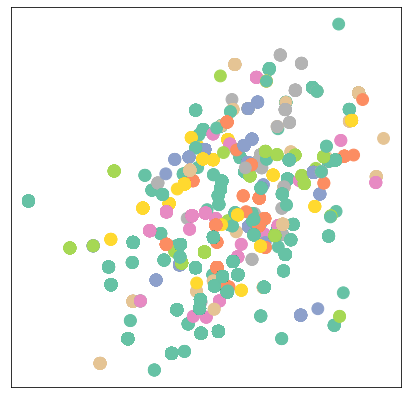

In [16]:
model = GCN(d)

_, h = model(d.x, d.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize(h, color=d.y)

In [ ]:
G = to_networkx(d, to_undirected=True)
#visualize(G, color=d.y)

tensor(4.2234, grad_fn=<NllLossBackward>)


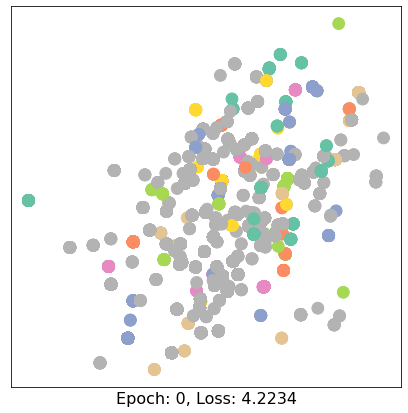

tensor(4.0927, grad_fn=<NllLossBackward>)
tensor(3.9683, grad_fn=<NllLossBackward>)
tensor(3.8489, grad_fn=<NllLossBackward>)
tensor(3.7373, grad_fn=<NllLossBackward>)
tensor(3.6353, grad_fn=<NllLossBackward>)
tensor(3.5426, grad_fn=<NllLossBackward>)
tensor(3.4575, grad_fn=<NllLossBackward>)
tensor(3.3781, grad_fn=<NllLossBackward>)
tensor(3.3026, grad_fn=<NllLossBackward>)
tensor(3.2299, grad_fn=<NllLossBackward>)


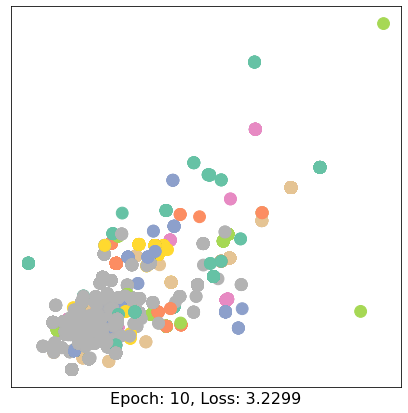

tensor(3.1591, grad_fn=<NllLossBackward>)
tensor(3.0898, grad_fn=<NllLossBackward>)
tensor(3.0216, grad_fn=<NllLossBackward>)
tensor(2.9544, grad_fn=<NllLossBackward>)
tensor(2.8880, grad_fn=<NllLossBackward>)
tensor(2.8224, grad_fn=<NllLossBackward>)
tensor(2.7576, grad_fn=<NllLossBackward>)
tensor(2.6934, grad_fn=<NllLossBackward>)
tensor(2.6300, grad_fn=<NllLossBackward>)


In [70]:
import time
#from IPython.display import Javascript  # Restrict height of output cell.
#display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN(d)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer


def train(data):
    optimizer.zero_grad()  # Clear gradients
    out, h = model(d.x, d.edge_index)  # Perform a single forward pass
    loss = criterion(out[d.train_mask], d.y[d.train_mask]) # calc loss on training nodes
    loss.backward()  # Derive gradients
    optimizer.step()  # Update parameters based on gradients
    return loss, h


for epoch in range(20):
    loss, h = train(d)
    print(loss)
    if epoch % 10 == 0:
        visualize(h, color=d.y, epoch=epoch, loss=loss)
        time.sleep(0.3)

In [17]:
#dgmc.DGMC(psi_1=batch2, psi_2=batch2, num_steps=3)

In [69]:
loss

tensor(2.6300, grad_fn=<NllLossBackward>)